In [1]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from scipy.stats import median_absolute_deviation

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif'})

flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
cmap = tol_cmap('rainbow_PuRd')
cmap_diverge = tol_cmap('sunset')

## Data and function definition

In [2]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)
select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0]

stars = stars[select_bitmasked]

stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [3]:
x = fits.open(tabfile)


In [4]:
def getspecpaths(tab):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(tab['TELESCOPE'], dtype = str)
    field = np.array(tab['FIELD'], dtype = str)
    sourceid = np.array(tab['APOGEE_ID'], dtype = str)
    length = len(sourceid)
    path = tuple((specdir + specname).format(TELESCOPE = telescope[i], FIELD = field[i], SOURCEID = sourceid[i]) 
                 for i in range(length))
    return path

def getapstarpath(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    return path
    

def getwavs(hdulist):
    header = hdulist[1].header
    CRVAL1 = header['CRVAL1']
    CDELT1 = header['CDELT1']
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(hdulist[1].data)))
    return wavs 

def getspec(path):
    hdulist = fits.open(path)
    spectrum = hdulist[1].data
    model = hdulist[3].data
    wavs = getwavs(hdulist)
    return (spectrum, model, wavs)

## Binning visualizations

In [5]:
CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']

CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
print('CA Cloud Stars:',  len(CA_inds))

CA_stars = stars[CA_inds]



CA Cloud Stars: 288


/uufs/chpc.utah.edu/sys/srcdir/pylib/3.6.3/biokevlar/biokevlar-0.7/.eggs/matplotlib-3.3.2-py3.6-linux-x86_64.egg/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


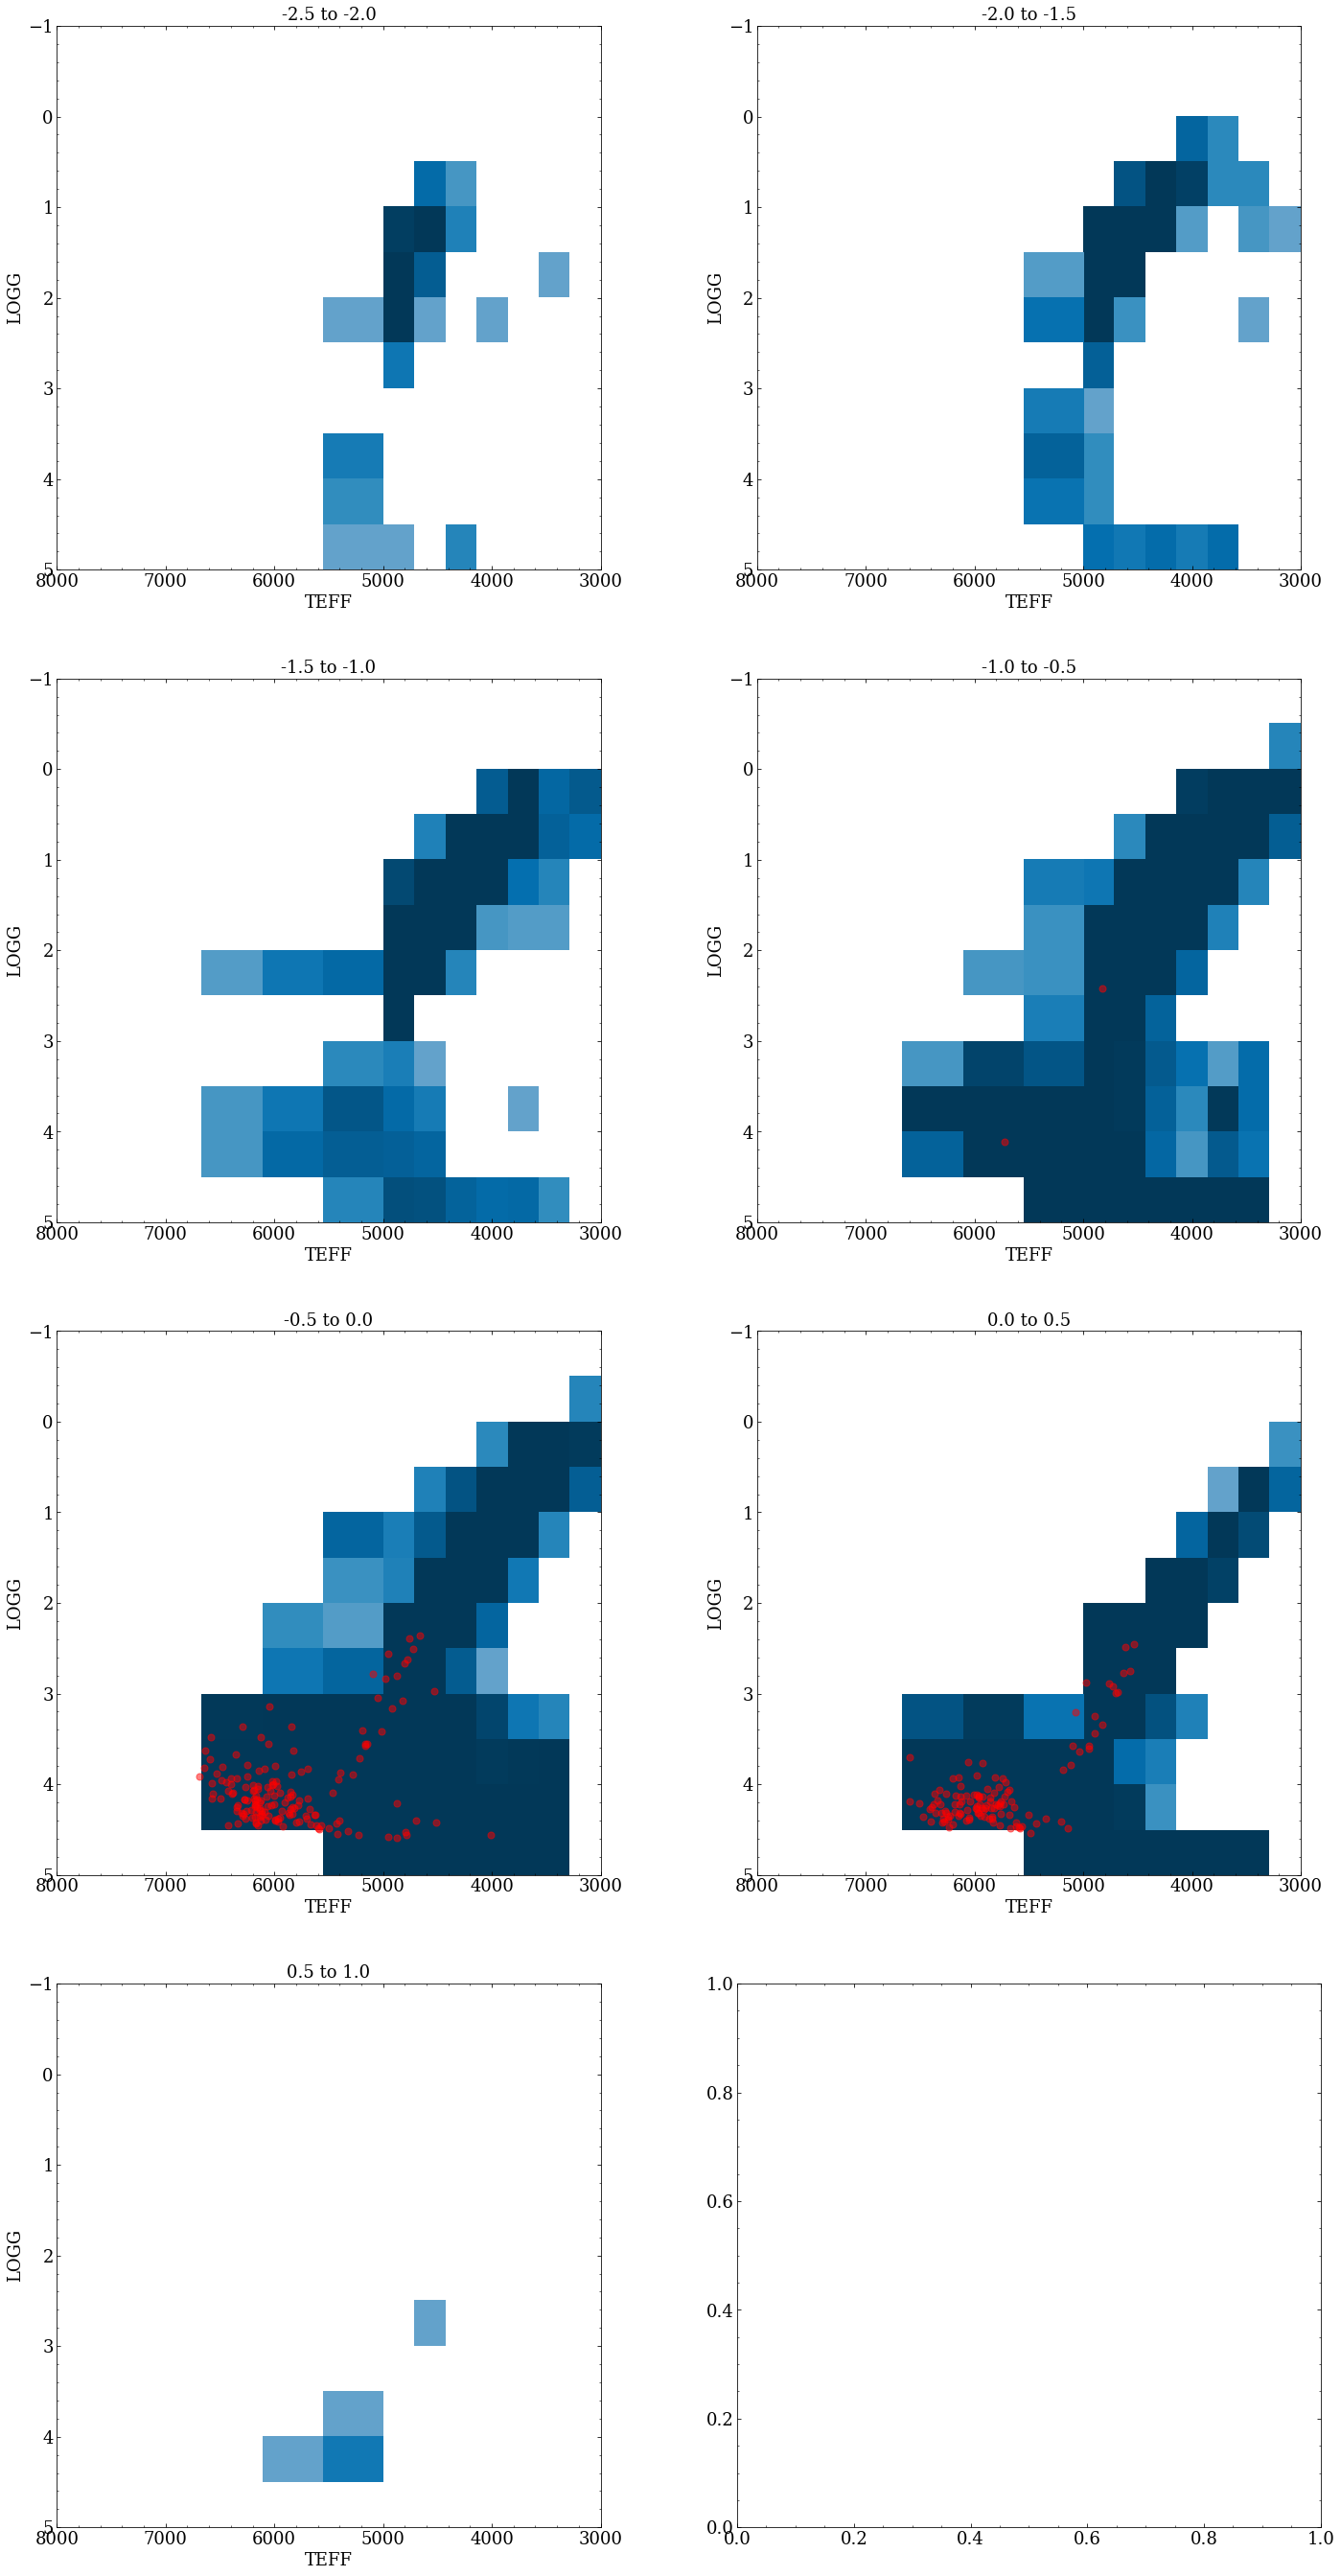

In [6]:
binmin, binmax = (2000, 8000)

fig, axs = plt.subplots(4,2, figsize = (24,48))

# teffbins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
# loggbins = np.arange(-1, 5.2, 0.2)

teffbins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]])
loggbins = np.arange(-1, 5.1, 0.5)    

def hr_hist_bins(ax, tab, fig = fig, teffbins = teffbins, loggbins = loggbins):
    binmin, binmax = (np.min(teffbins), np.max(teffbins))
    binmin_, binmax_ = (np.min(loggbins), np.max(loggbins))
    binsize = np.array([teffbins,loggbins])
    histrange = (teffbins, loggbins)
    hist = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = binsize)[0]
    hist[np.where(hist < 4)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)
    
#     image = ax.imshow(hist.T[:, -1:0:-1], cmap = 'PuBu', extent = (binmax,binmin, binmax_,binmin_), vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
        
    
    bins1 = np.concatenate([np.arange(3000, 5000, 250), [5000]])
    bins2 = np.concatenate([np.arange(5000,10000, 500), [10000]])
    hist1 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins1, loggbins))[0]
    hist1[np.where(hist1 < 4)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)


    image1 = ax.imshow(hist1.T[:, -1:0:-1], cmap = 'PuBu', extent = (5000,3000, 5,-1), norm = norm)#, vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
    hist2 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins2, loggbins))[0]
    hist2[np.where(hist2 < 4)] = np.nan
    image2 = ax.imshow(hist2.T[:, -1:0:-1], cmap = 'PuBu', extent = (10000,5000, 5,-1), norm = norm)# vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)

    
        
    ax.set_aspect((8000 - binmin) / 6)
#     fig.colorbar(image, ax = ax, label = 'Binned Stars',fraction=0.046)
    ax.set_xlim(8000, binmin)
    ax.set_ylim(binmax_, binmin_)
#     ax.set_xticks(np.arange(binmax, binmin, -1000))
    ax.set_xlabel('TEFF')
    ax.set_ylabel('LOGG')

def plot_hr(ax, tab, fig = fig):
    ax.scatter(tab['TEFF'], tab['LOGG'], color = 'r', s= 50, alpha = 0.5)

# fig.subplots_adjust(hspace=0.5)
m_h_bins = np.arange(-2.5, 1.1, .5)
for i in range(4):
    for j in range(2):
        if (i==3) & (j==1):
            break
        stars_restricted = stars[np.where((stars['M_H'] > m_h_bins[2*i+j]) & (stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
#         hr_hist(axs[i, j], stars_restricted)
#         hr_hist_bins(axs[i,j], stars_restricted, teffbins = teffbins, loggbins = loggbins)
        axs[i,j].set_title(str(round(m_h_bins[2*i+j],1))+  ' to ' + str(round(m_h_bins[2*i+j+1],1)))
        
        
        CA_stars_restricted = CA_stars[np.where((CA_stars['M_H'] > m_h_bins[2*i+j]) & (CA_stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
        hr_hist_bins(axs[i,j], stars_restricted)
        plot_hr(axs[i, j], CA_stars_restricted)
# hr_hist(axs[0,0], stars)
# hr_hist(axs[0,1], stars)
# hr_hist(axs[1,0], stars)
# hr_hist(axs[1,1], stars)
plt.show()

## Residuals
### Bitmasks

In [7]:
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []):
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

def create_errmask(err, threshold = 2):
    med = np.repeat(np.nanmedian(err, axis = -1), err.shape[-1]).reshape(err.shape)
    mask = np.zeros(err.shape)
    mask[err > threshold * med] = 1
    return mask

def get_starpixelcount(mask, count = 5):
#     print(mask.shape)
    n_remaining = len(mask) - np.sum(mask, axis = 0)
#     print(n_remaining.shape)
#     mask = np.zeros(n_remaining.shape)
#     mask[n_remaining < count] = 1
    return n_remaining

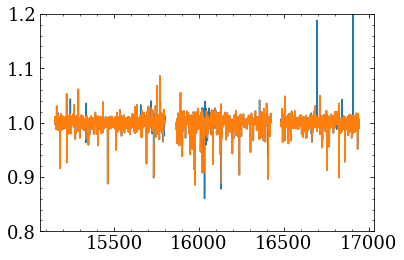

In [8]:
i = 2000
startest = stars[i:i+1]
hdulist1 = fits.open(getspecpaths(startest)[0])
bitmask = fits.open(getapstarpath(hdulist1))[3].data[0,:]
# mask = (np.bitwise_and(bitmask,11) == 1).astype(int) + (np.bitwise_and(bitmask, 13) == 1).astype(int) + (np.bitwise_and(bitmask, 14) == 1).astype(int)
# print(bitmask)
mask = create_mask(bitmask, skipflags = [10, 11]) #11 causes big gaps in the data - skipping medium and low persistence


fig = plt.figure()
ax = plt.subplot()
def quickplot(hdulist, ax, mask = None, lims = None):
    wavs = getwavs(hdulist)
    spec = hdulist[1].data
    mod = hdulist[3].data
    if mask is not None:
        wavs = ma.array(wavs, mask = mask)
        spec = ma.array(spec,mask = mask)
        mod = ma.array(mod, mask = mask)
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        res = np.divide(spec,mod)
    
    ax.plot(wavs, res)
    ax.set_ylim(.8, 1.2)
    
quickplot(hdulist1, ax)# mask = bitmask)
quickplot(hdulist1, ax, mask = mask)
plt.show()

0.0049906158819794655


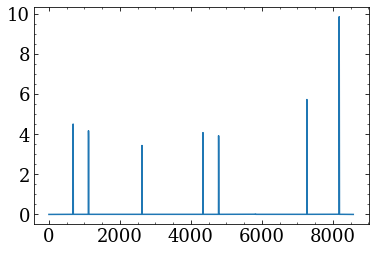

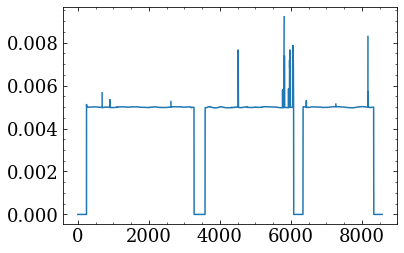

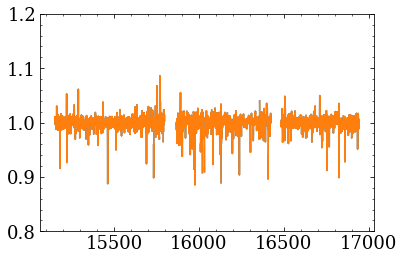

In [9]:
plt.plot(hdulist1[2].data)
print(np.median(hdulist1[2].data))
plt.show()

dat = hdulist1[2].data
m = np.zeros(len(dat))
m[np.where(dat > 2 * np.nanmedian(dat))[0]] = 1
dat_m = ma.array(dat, mask = m)
plt.plot(dat_m)
plt.show()

# fig, axs = plt.subplots(2,1)
# ax = axs[0]
fig = plt.figure()
ax = plt.subplot()
mask_errs = create_errmask(hdulist1[2].data, threshold = 2)
mask_ = mask + mask_errs
# quickplot(hdulist1, ax)
quickplot(hdulist1, ax, mask = mask)
quickplot(hdulist1, ax, mask = mask_)
plt.show()

In [10]:
teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.around(np.arange(-1, 5.2, 0.2), 2)
m_h_bins = np.around(np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]]), 2)

# teff_bins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]])
# logg_bins = np.arange(-1, 5.1, 0.5)
# m_h_bins = np.concatenate([np.arange(-2.5, 1.0, .3), [1]])

# CA_stars['RES_STD'] = np.empty(len(CA_stars))
# CA_stars['BINNED'] = np.zeros(len(CA_stars))

# teff_bins = np.append(np.arange(3000, 10000, 2000), np.arange(10000, 22000, 2000))
# print(len(teff_bins))
# logg_bins = np.arange(0, 5, 0.5)
# print(len(logg_bins))
# m_h_bins = np.arange(-2.5, 1, 0.5)
# print(len(m_h_bins))

In [ ]:
def get_selected_stars(tab, teff_bin, logg_bin, m_h_bin, return_indices = False):
    with np.errstate(divide='ignore', invalid = 'ignore'):
        indices = np.where((tab['TEFF'] >= teff_bin[0]) & (tab['TEFF'] < teff_bin[1]) & 
                            (tab['LOGG'] >= logg_bin[0]) & (tab['LOGG'] < logg_bin[1]) & 
                            (tab['M_H'] >= m_h_bin[0]) & (tab['M_H'] < m_h_bin[1]))[0]
    if return_indices:
        return indices
    else:
        return tab[indices]

# ALTERNATE VERSION USING np.logical_and, which seems to be a little slower    
# def get_selected_stars(tab, teff_bin, logg_bin, m_h_bin, return_indices = False):
#     with np.errstate(divide = 'ignore', invalid = 'ignore'):
#         teff = tab['TEFF']
#         logg = tab['LOGG']
#         m_h = tab['M_H']
#         bool_indices = np.logical_and.reduce([teff > teff_bin[0], teff < teff_bin[1], 
#                                               logg > logg_bin[0], logg < logg_bin[1],
#                                               m_h > m_h_bin[0], m_h < m_h_bin[1]])
#         return bool_indices


In [ ]:
cols = ['teff_low', 'teff_high', 'logg_low', 'logg_high', 'm_h_low', 'm_h_high', 
       'nstars', 'rest_std_median', 'res_std_mean', 'fname', 'i', 'j', 'k']
size = (len(teff_bins) - 1) * (len(logg_bins) - 1) * (len(m_h_bins) - 1)

table_contents = np.zeros((size, len(cols)), dtype = 'object')

def updateMetaTable(index, items, contents = table_contents):
    contents[index, :] = items
    return contents

# CALCULATES RESIDUALS
for i in tqdm(range(len(teff_bins)-1), total = len(teff_bins)):
    header = fits.Header()
    header['COMMENT'] = 'Generated ' + str(datetime.datetime.now())
    data_hdus = [fits.PrimaryHDU(header = header)]
    
    for j in range(len(logg_bins)-1):
        
        for k in range(len(m_h_bins)-1):
            teff_bin = (teff_bins[i], teff_bins[i+1])
            logg_bin = (logg_bins[j], logg_bins[j+1])
            m_h_bin = (m_h_bins[k], m_h_bins[k+1])
            
            fname = 'ResidualsFiles/Residuals_TeffBin{low}_{high}.fits'.format(low = teff_bin[0], 
                                                                                  high = teff_bin[1])
            
            COUNT = k + (len(m_h_bins)-1) * j + (len(m_h_bins)-1) * (len(logg_bins)-1)  * i
            
            
            # get stars within bin from stars tab
            selected_i = get_selected_stars(stars, teff_bin, logg_bin, m_h_bin, return_indices = True)
            select = stars[selected_i]
            
            # get spectra names
            stars_names = getspecpaths(select)
    
            nstars = len(stars_names)
            if nstars > 0:
                print('bin', teff_bin, logg_bin, m_h_bin, 'stars in bin', len(stars_names))
                
#                 for name in stars_names:
#                     hdu = fits.open(name)
                    
#                     asptarflags = fits.opens(getapstarpath(hdu))[3].data[0,:]
#                     apstarflags = 
                    
                hdus = tuple(fits.open(name) for name in stars_names)
                headers = tuple(hdu[1].header for hdu in hdus)
                CRVAL1 = headers[0]['CRVAL1']
                CDELT1 = headers[0]['CDELT1']
                
                # Create mask array, starting with bitmasks
                apStar = tuple(getapstarpath(hdu_) for hdu_ in hdus)
                bitmask = np.array(tuple(fits.open(name)[3].data[0,:] for name in apStar))
                mask = create_mask(bitmask, skipflags = [10,11]).astype(int)
                # Now add a mask for the apscapStar errors
                errors = np.array(tuple(hdu[2].data for hdu in hdus))
                mask = mask + create_errmask(errors, threshold = 1.8)
                mask = mask.astype(bool)
                # Now create a separate mask for the where the number statistics might be bad
                stars_per_pix = get_starpixelcount(mask)
#                 mask = (mask + count_mask).astype(bool)
                
                
                
#                 mask = np.zeros(mask.shape)
                
                # Get arrays of spectra and models, size: nstars * npixels
                spectra = ma.array(tuple(hdu[1].data for hdu in hdus), mask = mask)
                models = ma.array(tuple(hdu[3].data for hdu in hdus), mask = mask)
#                 errors = ma.array(tuple(hdu[2].data for hdu in hdus), )
                
                for hdu in hdus: #hopefully clear up some space!
                    hdu.close()
                    
                # Calculate stellar residuals
                with np.errstate(divide='ignore', invalid = 'ignore'):
                    residuals = spectra / models
                resfilled = ma.filled(residuals, np.nan) #filled for some purposes


                    
                # Take median of each array, pixel-wise    
                residuals_median = ma.median(residuals, axis = 0)
                resstd = ma.std(residuals, ddof = 1, axis = 0)                
                residuals_mean = ma.mean(residuals, axis = 0)                
                medabsdev = median_absolute_deviation(residuals, axis = 0, nan_policy = 'omit')                
                perc16 = np.nanpercentile(resfilled, 16, axis = 0)
                perc84 = np.nanpercentile(resfilled, 84, axis = 0)
                
                savedata = [residuals_median, residuals_mean, resstd, medabsdev, perc16, perc84]
                savecols = ['res_median', 'res_mean', 'res_std', 'res_med_absdev', 'res_perc16', 'res_perc84']
                
#                 wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(residuals_median))) # Define wavelengths 

                
                # Plotting
#                 tabrow = [teff_bin[0], teff_bin[1], logg_bin[0], logg_bin[1], m_h_bin[0], m_h_bin[1], nstars, fname, i, j, k]
#                 errmedian = np.median(errors)
#                 fig, axs = plt.subplots(2,1, figsize = (12,8), sharex = True, gridspec_kw = {'height_ratios':(0.75, 0.25)})
#                 ax, errax = tuple(axs)
#                 for row in range(len(residuals)):
#                     ax.plot(wavs, residuals[row,:].data, linestyle = 'dashed', linewidth = 0.2)
#                     errax.plot(wavs, errors[row,:].data, linestyle = 'dashed', linewidth = 0.8)
#                 ax.plot(wavs, residuals_median, linewidth = 0.8, color = 'k')
#                 ax.set_xlim(15250, 15500)
#                 ax.set_ylim(.8, 1.2)
#                 errax.set_ylim(0, 5 * errmedian)
#                 ax.set_ylabel('Residual')
#                 errax.set_xlabel('Wavelength ($\circ{A}$)')
#                 errax.set_ylabel('Spectra Err')
#                 plt.show()
                
        

#                 h = fits.ImageHDU(data = np.array([residuals_median.data, resstd.data, count_mask[0,:]]))
                h = fits.ImageHDU(data = savedata) #THIS WON'T WORK
                h.header['NBIN'] = nstars
                h.header['TMIN'] = teff_bin[0]
                h.header['TMAX'] = teff_bin[1]
                h.header['GMIN'] = logg_bin[0]
                h.header['GMAX'] = logg_bin[1]
                h.header['MMIN'] = m_h_bin[0]
                h.header['MMAX'] = m_h_bin[1]
                h.header['CRVAL1'] = CRVAL1
                h.header['CDELT1'] = CDELT1
                h.header['COLS'] = str(savecols)
                
                errmedian = np.nanmedian(resstd)
                errmean = np.nanmean(resstd)
                
            else: # if no stars in bin
                h = fits.ImageHDU()
                h.header['NBIN'] = 0
                h.header['TMIN'] = teff_bin[0]
                h.header['TMAX'] = teff_bin[1]
                h.header['GMIN'] = logg_bin[0]
                h.header['GMAX'] = logg_bin[1]
                h.header['MMIN'] = m_h_bin[0]
                h.header['MMAX'] = m_h_bin[1]
                h.header['CRVAL1'] = None
                h.header['CDELT1'] = None
                h.header['COLS'] = ''
                
                errmedian = np.nan
                errmean = np.nan
            
            tabrow = [teff_bin[0], teff_bin[1], logg_bin[0], logg_bin[1], m_h_bin[0], m_h_bin[1],
                      nstars, errmedian, errmean, fname, i, j, k]
            table_contents = updateMetaTable(COUNT, tabrow)
            data_hdus.append(h)
            
    data_hdus = fits.HDUList(data_hdus)
    data_hdus.writeto(fname, overwrite = True)

datatype = [int, int, float, float, float, float, int, float, float, str, int, int, int]
meta_table = Table(names = cols, data = table_contents)
# tabcols = meta_table.columns
for i in range(len(cols)):
    col = cols[i]
    meta_table[col] = meta_table[col].astype(datatype[i])

meta_table.write('ResidualsFiles/meta_table.fits', format = 'fits', overwrite = True)


  5%|▌         | 4/75 [00:09<02:54,  2.46s/it]

bin (3200, 3250) (-0.0, 0.2) (-0.1, 0.1) stars in bin 1


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


bin (3200, 3250) (0.2, 0.4) (0.1, 0.3) stars in bin 1


  7%|▋         | 5/75 [00:14<03:24,  2.93s/it]

bin (3250, 3300) (-0.0, 0.2) (-1.1, -0.9) stars in bin 1
bin (3250, 3300) (-0.0, 0.2) (-0.7, -0.5) stars in bin 1
bin (3250, 3300) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3250, 3300) (0.2, 0.4) (-1.1, -0.9) stars in bin 4
bin (3250, 3300) (0.2, 0.4) (-0.9, -0.7) stars in bin 2
bin (3250, 3300) (0.2, 0.4) (-0.7, -0.5) stars in bin 3
bin (3250, 3300) (0.2, 0.4) (-0.3, -0.1) stars in bin 1
bin (3250, 3300) (0.2, 0.4) (-0.1, 0.1) stars in bin 1
bin (3250, 3300) (0.2, 0.4) (0.1, 0.3) stars in bin 2
bin (3250, 3300) (0.4, 0.6) (-1.1, -0.9) stars in bin 1
bin (3250, 3300) (0.4, 0.6) (-0.7, -0.5) stars in bin 2
bin (3250, 3300) (0.6, 0.8) (-1.1, -0.9) stars in bin 1
bin (3250, 3300) (0.8, 1.0) (-0.7, -0.5) stars in bin 1


  8%|▊         | 6/75 [00:32<06:18,  5.48s/it]

bin (3300, 3350) (-0.2, -0.0) (-0.7, -0.5) stars in bin 1
bin (3300, 3350) (-0.2, -0.0) (-0.3, -0.1) stars in bin 3
bin (3300, 3350) (-0.0, 0.2) (-0.9, -0.7) stars in bin 1
bin (3300, 3350) (-0.0, 0.2) (-0.5, -0.3) stars in bin 1
bin (3300, 3350) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3300, 3350) (0.2, 0.4) (-1.4, -1.1) stars in bin 3
bin (3300, 3350) (0.2, 0.4) (-1.1, -0.9) stars in bin 3
bin (3300, 3350) (0.2, 0.4) (-0.7, -0.5) stars in bin 3
bin (3300, 3350) (0.2, 0.4) (-0.5, -0.3) stars in bin 2
bin (3300, 3350) (0.2, 0.4) (-0.1, 0.1) stars in bin 4
bin (3300, 3350) (0.4, 0.6) (-2.0, -1.7) stars in bin 1
bin (3300, 3350) (0.4, 0.6) (-1.7, -1.4) stars in bin 1
bin (3300, 3350) (0.4, 0.6) (-1.4, -1.1) stars in bin 4
bin (3300, 3350) (0.4, 0.6) (-1.1, -0.9) stars in bin 3
bin (3300, 3350) (0.4, 0.6) (-0.9, -0.7) stars in bin 2
bin (3300, 3350) (0.4, 0.6) (0.1, 0.3) stars in bin 2
bin (3300, 3350) (0.6, 0.8) (-1.4, -1.1) stars in bin 1
bin (3300, 3350) (0.6, 0.8) (0.3, 0.5) stars

  9%|▉         | 7/75 [00:59<09:37,  8.49s/it]

bin (3350, 3400) (-0.2, -0.0) (-0.7, -0.5) stars in bin 3
bin (3350, 3400) (-0.2, -0.0) (-0.5, -0.3) stars in bin 3
bin (3350, 3400) (-0.0, 0.2) (-1.1, -0.9) stars in bin 1
bin (3350, 3400) (-0.0, 0.2) (-0.9, -0.7) stars in bin 3
bin (3350, 3400) (-0.0, 0.2) (-0.7, -0.5) stars in bin 9
bin (3350, 3400) (-0.0, 0.2) (-0.5, -0.3) stars in bin 2
bin (3350, 3400) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3350, 3400) (0.2, 0.4) (-1.4, -1.1) stars in bin 5
bin (3350, 3400) (0.2, 0.4) (-1.1, -0.9) stars in bin 1
bin (3350, 3400) (0.2, 0.4) (-0.9, -0.7) stars in bin 1
bin (3350, 3400) (0.2, 0.4) (-0.7, -0.5) stars in bin 6
bin (3350, 3400) (0.2, 0.4) (-0.5, -0.3) stars in bin 3
bin (3350, 3400) (0.2, 0.4) (-0.3, -0.1) stars in bin 3
bin (3350, 3400) (0.2, 0.4) (-0.1, 0.1) stars in bin 4
bin (3350, 3400) (0.4, 0.6) (-1.7, -1.4) stars in bin 1
bin (3350, 3400) (0.4, 0.6) (-1.4, -1.1) stars in bin 7
bin (3350, 3400) (0.4, 0.6) (-0.7, -0.5) stars in bin 1
bin (3350, 3400) (0.4, 0.6) (-0.5, -0.3)

 11%|█         | 8/75 [01:39<13:53, 12.45s/it]

bin (3400, 3450) (-0.2, -0.0) (-0.7, -0.5) stars in bin 2
bin (3400, 3450) (-0.2, -0.0) (-0.5, -0.3) stars in bin 3
bin (3400, 3450) (-0.0, 0.2) (-0.9, -0.7) stars in bin 7
bin (3400, 3450) (-0.0, 0.2) (-0.7, -0.5) stars in bin 6
bin (3400, 3450) (-0.0, 0.2) (-0.5, -0.3) stars in bin 6
bin (3400, 3450) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3400, 3450) (0.2, 0.4) (-1.4, -1.1) stars in bin 5
bin (3400, 3450) (0.2, 0.4) (-1.1, -0.9) stars in bin 4
bin (3400, 3450) (0.2, 0.4) (-0.9, -0.7) stars in bin 5
bin (3400, 3450) (0.2, 0.4) (-0.7, -0.5) stars in bin 8
bin (3400, 3450) (0.2, 0.4) (-0.5, -0.3) stars in bin 8
bin (3400, 3450) (0.2, 0.4) (-0.3, -0.1) stars in bin 4
bin (3400, 3450) (0.2, 0.4) (-0.1, 0.1) stars in bin 1
bin (3400, 3450) (0.4, 0.6) (-1.4, -1.1) stars in bin 1
bin (3400, 3450) (0.4, 0.6) (-1.1, -0.9) stars in bin 2
bin (3400, 3450) (0.4, 0.6) (-0.9, -0.7) stars in bin 1
bin (3400, 3450) (0.4, 0.6) (-0.7, -0.5) stars in bin 5
bin (3400, 3450) (0.4, 0.6) (-0.5, -0.3) 

 12%|█▏        | 9/75 [02:26<17:54, 16.29s/it]

bin (3450, 3500) (-0.2, -0.0) (-0.7, -0.5) stars in bin 4
bin (3450, 3500) (-0.2, -0.0) (-0.5, -0.3) stars in bin 1
bin (3450, 3500) (-0.0, 0.2) (-1.1, -0.9) stars in bin 1
bin (3450, 3500) (-0.0, 0.2) (-0.9, -0.7) stars in bin 10
bin (3450, 3500) (-0.0, 0.2) (-0.7, -0.5) stars in bin 15
bin (3450, 3500) (-0.0, 0.2) (-0.5, -0.3) stars in bin 6
bin (3450, 3500) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3450, 3500) (0.2, 0.4) (-1.4, -1.1) stars in bin 4
bin (3450, 3500) (0.2, 0.4) (-1.1, -0.9) stars in bin 4
bin (3450, 3500) (0.2, 0.4) (-0.9, -0.7) stars in bin 12
bin (3450, 3500) (0.2, 0.4) (-0.7, -0.5) stars in bin 27
bin (3450, 3500) (0.2, 0.4) (-0.5, -0.3) stars in bin 9
bin (3450, 3500) (0.2, 0.4) (-0.3, -0.1) stars in bin 6
bin (3450, 3500) (0.4, 0.6) (-1.4, -1.1) stars in bin 1
bin (3450, 3500) (0.4, 0.6) (-1.1, -0.9) stars in bin 2
bin (3450, 3500) (0.4, 0.6) (-0.9, -0.7) stars in bin 6
bin (3450, 3500) (0.4, 0.6) (-0.7, -0.5) stars in bin 18
bin (3450, 3500) (0.4, 0.6) (-0.5,

 13%|█▎        | 10/75 [03:20<21:44, 20.07s/it]

bin (3500, 3550) (-0.2, -0.0) (-0.7, -0.5) stars in bin 1
bin (3500, 3550) (-0.2, -0.0) (-0.5, -0.3) stars in bin 2
bin (3500, 3550) (-0.0, 0.2) (-0.9, -0.7) stars in bin 10
bin (3500, 3550) (-0.0, 0.2) (-0.7, -0.5) stars in bin 22
bin (3500, 3550) (-0.0, 0.2) (-0.5, -0.3) stars in bin 5
bin (3500, 3550) (0.2, 0.4) (-0.9, -0.7) stars in bin 15
bin (3500, 3550) (0.2, 0.4) (-0.7, -0.5) stars in bin 25
bin (3500, 3550) (0.2, 0.4) (-0.5, -0.3) stars in bin 7
bin (3500, 3550) (0.2, 0.4) (-0.3, -0.1) stars in bin 7
bin (3500, 3550) (0.4, 0.6) (-1.7, -1.4) stars in bin 1
bin (3500, 3550) (0.4, 0.6) (-1.4, -1.1) stars in bin 5
bin (3500, 3550) (0.4, 0.6) (-1.1, -0.9) stars in bin 3
bin (3500, 3550) (0.4, 0.6) (-0.9, -0.7) stars in bin 7
bin (3500, 3550) (0.4, 0.6) (-0.7, -0.5) stars in bin 24
bin (3500, 3550) (0.4, 0.6) (-0.5, -0.3) stars in bin 25
bin (3500, 3550) (0.4, 0.6) (-0.3, -0.1) stars in bin 8
bin (3500, 3550) (0.4, 0.6) (-0.1, 0.1) stars in bin 3
bin (3500, 3550) (0.6, 0.8) (-2.0, -

 15%|█▍        | 11/75 [04:21<25:24, 23.81s/it]

bin (3550, 3600) (-0.2, -0.0) (-0.9, -0.7) stars in bin 1
bin (3550, 3600) (-0.2, -0.0) (-0.7, -0.5) stars in bin 1
bin (3550, 3600) (-0.2, -0.0) (-0.5, -0.3) stars in bin 1
bin (3550, 3600) (-0.0, 0.2) (-0.9, -0.7) stars in bin 4
bin (3550, 3600) (-0.0, 0.2) (-0.7, -0.5) stars in bin 35
bin (3550, 3600) (-0.0, 0.2) (-0.5, -0.3) stars in bin 7
bin (3550, 3600) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3550, 3600) (0.2, 0.4) (-1.7, -1.4) stars in bin 1
bin (3550, 3600) (0.2, 0.4) (-1.1, -0.9) stars in bin 3
bin (3550, 3600) (0.2, 0.4) (-0.9, -0.7) stars in bin 24
bin (3550, 3600) (0.2, 0.4) (-0.7, -0.5) stars in bin 42
bin (3550, 3600) (0.2, 0.4) (-0.5, -0.3) stars in bin 21
bin (3550, 3600) (0.2, 0.4) (-0.3, -0.1) stars in bin 5
bin (3550, 3600) (0.4, 0.6) (-1.7, -1.4) stars in bin 1
bin (3550, 3600) (0.4, 0.6) (-1.4, -1.1) stars in bin 2
bin (3550, 3600) (0.4, 0.6) (-1.1, -0.9) stars in bin 4
bin (3550, 3600) (0.4, 0.6) (-0.9, -0.7) stars in bin 12
bin (3550, 3600) (0.4, 0.6) (-0.7

 16%|█▌        | 12/75 [05:51<30:47, 29.33s/it]

bin (3600, 3650) (-0.0, 0.2) (-0.9, -0.7) stars in bin 14
bin (3600, 3650) (-0.0, 0.2) (-0.7, -0.5) stars in bin 20
bin (3600, 3650) (-0.0, 0.2) (-0.5, -0.3) stars in bin 8
bin (3600, 3650) (0.2, 0.4) (-1.4, -1.1) stars in bin 2
bin (3600, 3650) (0.2, 0.4) (-1.1, -0.9) stars in bin 7
bin (3600, 3650) (0.2, 0.4) (-0.9, -0.7) stars in bin 34
bin (3600, 3650) (0.2, 0.4) (-0.7, -0.5) stars in bin 71
bin (3600, 3650) (0.2, 0.4) (-0.5, -0.3) stars in bin 30
bin (3600, 3650) (0.4, 0.6) (-1.1, -0.9) stars in bin 9
bin (3600, 3650) (0.4, 0.6) (-0.9, -0.7) stars in bin 20
bin (3600, 3650) (0.4, 0.6) (-0.7, -0.5) stars in bin 51
bin (3600, 3650) (0.4, 0.6) (-0.5, -0.3) stars in bin 52
bin (3600, 3650) (0.4, 0.6) (-0.3, -0.1) stars in bin 14
bin (3600, 3650) (0.6, 0.8) (-1.4, -1.1) stars in bin 2
bin (3600, 3650) (0.6, 0.8) (-1.1, -0.9) stars in bin 3
bin (3600, 3650) (0.6, 0.8) (-0.9, -0.7) stars in bin 26
bin (3600, 3650) (0.6, 0.8) (-0.7, -0.5) stars in bin 37
bin (3600, 3650) (0.6, 0.8) (-0.5,

 17%|█▋        | 13/75 [12:19<58:48, 56.91s/it]

bin (3650, 3700) (-0.0, 0.2) (-1.1, -0.9) stars in bin 4
bin (3650, 3700) (-0.0, 0.2) (-0.9, -0.7) stars in bin 12
bin (3650, 3700) (-0.0, 0.2) (-0.7, -0.5) stars in bin 19
bin (3650, 3700) (-0.0, 0.2) (-0.5, -0.3) stars in bin 2
bin (3650, 3700) (0.2, 0.4) (-1.4, -1.1) stars in bin 1
bin (3650, 3700) (0.2, 0.4) (-1.1, -0.9) stars in bin 9
bin (3650, 3700) (0.2, 0.4) (-0.9, -0.7) stars in bin 40
bin (3650, 3700) (0.2, 0.4) (-0.7, -0.5) stars in bin 106
bin (3650, 3700) (0.2, 0.4) (-0.5, -0.3) stars in bin 53
bin (3650, 3700) (0.2, 0.4) (-0.3, -0.1) stars in bin 2
bin (3650, 3700) (0.4, 0.6) (-1.1, -0.9) stars in bin 6
bin (3650, 3700) (0.4, 0.6) (-0.9, -0.7) stars in bin 36
bin (3650, 3700) (0.4, 0.6) (-0.7, -0.5) stars in bin 116
bin (3650, 3700) (0.4, 0.6) (-0.5, -0.3) stars in bin 58
bin (3650, 3700) (0.4, 0.6) (-0.3, -0.1) stars in bin 14
bin (3650, 3700) (0.6, 0.8) (-1.7, -1.4) stars in bin 1
bin (3650, 3700) (0.6, 0.8) (-1.4, -1.1) stars in bin 1
bin (3650, 3700) (0.6, 0.8) (-1.1

 19%|█▊        | 14/75 [21:06<1:31:58, 90.47s/it]

bin (3700, 3750) (-0.0, 0.2) (-1.1, -0.9) stars in bin 2
bin (3700, 3750) (-0.0, 0.2) (-0.9, -0.7) stars in bin 14
bin (3700, 3750) (-0.0, 0.2) (-0.7, -0.5) stars in bin 6
bin (3700, 3750) (-0.0, 0.2) (-0.5, -0.3) stars in bin 1
bin (3700, 3750) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3700, 3750) (0.2, 0.4) (-1.4, -1.1) stars in bin 2
bin (3700, 3750) (0.2, 0.4) (-1.1, -0.9) stars in bin 11
bin (3700, 3750) (0.2, 0.4) (-0.9, -0.7) stars in bin 46
bin (3700, 3750) (0.2, 0.4) (-0.7, -0.5) stars in bin 66
bin (3700, 3750) (0.2, 0.4) (-0.5, -0.3) stars in bin 67
bin (3700, 3750) (0.2, 0.4) (-0.3, -0.1) stars in bin 1
bin (3700, 3750) (0.4, 0.6) (-1.7, -1.4) stars in bin 1
bin (3700, 3750) (0.4, 0.6) (-1.4, -1.1) stars in bin 5
bin (3700, 3750) (0.4, 0.6) (-1.1, -0.9) stars in bin 18
bin (3700, 3750) (0.4, 0.6) (-0.9, -0.7) stars in bin 56
bin (3700, 3750) (0.4, 0.6) (-0.7, -0.5) stars in bin 195
bin (3700, 3750) (0.4, 0.6) (-0.5, -0.3) stars in bin 104
bin (3700, 3750) (0.4, 0.6) (-0.

 20%|██        | 15/75 [30:13<2:00:53, 120.89s/it]

bin (3750, 3800) (-0.0, 0.2) (-1.1, -0.9) stars in bin 2
bin (3750, 3800) (-0.0, 0.2) (-0.9, -0.7) stars in bin 4
bin (3750, 3800) (-0.0, 0.2) (-0.7, -0.5) stars in bin 9
bin (3750, 3800) (-0.0, 0.2) (-0.5, -0.3) stars in bin 1
bin (3750, 3800) (-0.0, 0.2) (-0.3, -0.1) stars in bin 1
bin (3750, 3800) (0.2, 0.4) (-1.7, -1.4) stars in bin 1
bin (3750, 3800) (0.2, 0.4) (-1.4, -1.1) stars in bin 2
bin (3750, 3800) (0.2, 0.4) (-1.1, -0.9) stars in bin 14
bin (3750, 3800) (0.2, 0.4) (-0.9, -0.7) stars in bin 49
bin (3750, 3800) (0.2, 0.4) (-0.7, -0.5) stars in bin 55
bin (3750, 3800) (0.2, 0.4) (-0.5, -0.3) stars in bin 32
bin (3750, 3800) (0.4, 0.6) (-1.4, -1.1) stars in bin 4
bin (3750, 3800) (0.4, 0.6) (-1.1, -0.9) stars in bin 21
bin (3750, 3800) (0.4, 0.6) (-0.9, -0.7) stars in bin 78
bin (3750, 3800) (0.4, 0.6) (-0.7, -0.5) stars in bin 191
bin (3750, 3800) (0.4, 0.6) (-0.5, -0.3) stars in bin 119
bin (3750, 3800) (0.4, 0.6) (-0.3, -0.1) stars in bin 7
bin (3750, 3800) (0.6, 0.8) (-1.4

 21%|██▏       | 16/75 [39:43<2:26:28, 148.96s/it]

bin (3800, 3850) (-0.0, 0.2) (-1.4, -1.1) stars in bin 1
bin (3800, 3850) (-0.0, 0.2) (-1.1, -0.9) stars in bin 4
bin (3800, 3850) (-0.0, 0.2) (-0.9, -0.7) stars in bin 11
bin (3800, 3850) (-0.0, 0.2) (-0.7, -0.5) stars in bin 10
bin (3800, 3850) (-0.0, 0.2) (-0.5, -0.3) stars in bin 1
bin (3800, 3850) (0.2, 0.4) (-1.4, -1.1) stars in bin 2
bin (3800, 3850) (0.2, 0.4) (-1.1, -0.9) stars in bin 16
bin (3800, 3850) (0.2, 0.4) (-0.9, -0.7) stars in bin 33
bin (3800, 3850) (0.2, 0.4) (-0.7, -0.5) stars in bin 27
bin (3800, 3850) (0.2, 0.4) (-0.5, -0.3) stars in bin 19
bin (3800, 3850) (0.4, 0.6) (-1.4, -1.1) stars in bin 20
bin (3800, 3850) (0.4, 0.6) (-1.1, -0.9) stars in bin 28
bin (3800, 3850) (0.4, 0.6) (-0.9, -0.7) stars in bin 136
bin (3800, 3850) (0.4, 0.6) (-0.7, -0.5) stars in bin 189
bin (3800, 3850) (0.4, 0.6) (-0.5, -0.3) stars in bin 90
bin (3800, 3850) (0.4, 0.6) (-0.3, -0.1) stars in bin 7
bin (3800, 3850) (0.6, 0.8) (-1.7, -1.4) stars in bin 1
bin (3800, 3850) (0.6, 0.8) (-

 23%|██▎       | 17/75 [50:08<2:51:05, 176.99s/it]

bin (3850, 3900) (-0.0, 0.2) (-1.1, -0.9) stars in bin 3
bin (3850, 3900) (-0.0, 0.2) (-0.9, -0.7) stars in bin 8
bin (3850, 3900) (-0.0, 0.2) (-0.7, -0.5) stars in bin 6
bin (3850, 3900) (-0.0, 0.2) (-0.5, -0.3) stars in bin 1
bin (3850, 3900) (0.2, 0.4) (-1.7, -1.4) stars in bin 1
bin (3850, 3900) (0.2, 0.4) (-1.4, -1.1) stars in bin 10
bin (3850, 3900) (0.2, 0.4) (-1.1, -0.9) stars in bin 11
bin (3850, 3900) (0.2, 0.4) (-0.9, -0.7) stars in bin 31
bin (3850, 3900) (0.2, 0.4) (-0.7, -0.5) stars in bin 22
bin (3850, 3900) (0.2, 0.4) (-0.5, -0.3) stars in bin 12
bin (3850, 3900) (0.4, 0.6) (-1.7, -1.4) stars in bin 3
bin (3850, 3900) (0.4, 0.6) (-1.4, -1.1) stars in bin 47
bin (3850, 3900) (0.4, 0.6) (-1.1, -0.9) stars in bin 72
bin (3850, 3900) (0.4, 0.6) (-0.9, -0.7) stars in bin 233
bin (3850, 3900) (0.4, 0.6) (-0.7, -0.5) stars in bin 166
bin (3850, 3900) (0.4, 0.6) (-0.5, -0.3) stars in bin 81
bin (3850, 3900) (0.4, 0.6) (-0.3, -0.1) stars in bin 3
bin (3850, 3900) (0.6, 0.8) (-1.

 24%|██▍       | 18/75 [1:01:31<3:14:50, 205.09s/it]

bin (3900, 3950) (-0.0, 0.2) (-1.4, -1.1) stars in bin 1
bin (3900, 3950) (-0.0, 0.2) (-1.1, -0.9) stars in bin 1
bin (3900, 3950) (-0.0, 0.2) (-0.9, -0.7) stars in bin 6
bin (3900, 3950) (-0.0, 0.2) (-0.7, -0.5) stars in bin 4
bin (3900, 3950) (-0.0, 0.2) (-0.5, -0.3) stars in bin 1
bin (3900, 3950) (0.2, 0.4) (-1.7, -1.4) stars in bin 3
bin (3900, 3950) (0.2, 0.4) (-1.4, -1.1) stars in bin 17
bin (3900, 3950) (0.2, 0.4) (-1.1, -0.9) stars in bin 11
bin (3900, 3950) (0.2, 0.4) (-0.9, -0.7) stars in bin 16
bin (3900, 3950) (0.2, 0.4) (-0.7, -0.5) stars in bin 38
bin (3900, 3950) (0.2, 0.4) (-0.5, -0.3) stars in bin 14
bin (3900, 3950) (0.4, 0.6) (-1.7, -1.4) stars in bin 9
bin (3900, 3950) (0.4, 0.6) (-1.4, -1.1) stars in bin 55
bin (3900, 3950) (0.4, 0.6) (-1.1, -0.9) stars in bin 80
bin (3900, 3950) (0.4, 0.6) (-0.9, -0.7) stars in bin 122
bin (3900, 3950) (0.4, 0.6) (-0.7, -0.5) stars in bin 93
bin (3900, 3950) (0.4, 0.6) (-0.5, -0.3) stars in bin 91
bin (3900, 3950) (0.4, 0.6) (-0.

 25%|██▌       | 19/75 [1:13:59<3:38:03, 233.64s/it]

bin (3950, 4000) (-0.0, 0.2) (-1.4, -1.1) stars in bin 1
bin (3950, 4000) (-0.0, 0.2) (-0.9, -0.7) stars in bin 4
bin (3950, 4000) (-0.0, 0.2) (-0.7, -0.5) stars in bin 4
bin (3950, 4000) (-0.0, 0.2) (-0.5, -0.3) stars in bin 1
bin (3950, 4000) (0.2, 0.4) (-2.0, -1.7) stars in bin 1
bin (3950, 4000) (0.2, 0.4) (-1.7, -1.4) stars in bin 5
bin (3950, 4000) (0.2, 0.4) (-1.4, -1.1) stars in bin 12
bin (3950, 4000) (0.2, 0.4) (-1.1, -0.9) stars in bin 12
bin (3950, 4000) (0.2, 0.4) (-0.9, -0.7) stars in bin 16
bin (3950, 4000) (0.2, 0.4) (-0.7, -0.5) stars in bin 32
bin (3950, 4000) (0.2, 0.4) (-0.5, -0.3) stars in bin 5
bin (3950, 4000) (0.4, 0.6) (-2.0, -1.7) stars in bin 2
bin (3950, 4000) (0.4, 0.6) (-1.7, -1.4) stars in bin 16
bin (3950, 4000) (0.4, 0.6) (-1.4, -1.1) stars in bin 55
bin (3950, 4000) (0.4, 0.6) (-1.1, -0.9) stars in bin 35
bin (3950, 4000) (0.4, 0.6) (-0.9, -0.7) stars in bin 35
bin (3950, 4000) (0.4, 0.6) (-0.7, -0.5) stars in bin 63
bin (3950, 4000) (0.4, 0.6) (-0.5, 

 27%|██▋       | 20/75 [1:26:52<3:58:53, 260.62s/it]

bin (4000, 4050) (-0.0, 0.2) (-1.1, -0.9) stars in bin 2
bin (4000, 4050) (-0.0, 0.2) (-0.9, -0.7) stars in bin 1
bin (4000, 4050) (0.2, 0.4) (-1.7, -1.4) stars in bin 7
bin (4000, 4050) (0.2, 0.4) (-1.4, -1.1) stars in bin 5
bin (4000, 4050) (0.2, 0.4) (-1.1, -0.9) stars in bin 12
bin (4000, 4050) (0.2, 0.4) (-0.9, -0.7) stars in bin 23
bin (4000, 4050) (0.2, 0.4) (-0.7, -0.5) stars in bin 13
bin (4000, 4050) (0.2, 0.4) (-0.5, -0.3) stars in bin 3
bin (4000, 4050) (0.4, 0.6) (-2.0, -1.7) stars in bin 3
bin (4000, 4050) (0.4, 0.6) (-1.7, -1.4) stars in bin 29
bin (4000, 4050) (0.4, 0.6) (-1.4, -1.1) stars in bin 41
bin (4000, 4050) (0.4, 0.6) (-1.1, -0.9) stars in bin 16
bin (4000, 4050) (0.4, 0.6) (-0.9, -0.7) stars in bin 28
bin (4000, 4050) (0.4, 0.6) (-0.7, -0.5) stars in bin 40
bin (4000, 4050) (0.4, 0.6) (-0.5, -0.3) stars in bin 43
bin (4000, 4050) (0.6, 0.8) (-1.7, -1.4) stars in bin 9
bin (4000, 4050) (0.6, 0.8) (-1.4, -1.1) stars in bin 154
bin (4000, 4050) (0.6, 0.8) (-1.1, 

 28%|██▊       | 21/75 [1:38:20<4:12:52, 280.98s/it]

bin (4050, 4100) (-0.0, 0.2) (-1.1, -0.9) stars in bin 1
bin (4050, 4100) (0.2, 0.4) (-1.7, -1.4) stars in bin 4
bin (4050, 4100) (0.2, 0.4) (-1.4, -1.1) stars in bin 4
bin (4050, 4100) (0.2, 0.4) (-1.1, -0.9) stars in bin 7
bin (4050, 4100) (0.2, 0.4) (-0.9, -0.7) stars in bin 1
bin (4050, 4100) (0.4, 0.6) (-2.0, -1.7) stars in bin 8
bin (4050, 4100) (0.4, 0.6) (-1.7, -1.4) stars in bin 12
bin (4050, 4100) (0.4, 0.6) (-1.4, -1.1) stars in bin 7
bin (4050, 4100) (0.4, 0.6) (-1.1, -0.9) stars in bin 3
bin (4050, 4100) (0.4, 0.6) (-0.7, -0.5) stars in bin 2
bin (4050, 4100) (0.4, 0.6) (-0.5, -0.3) stars in bin 2
bin (4050, 4100) (0.6, 0.8) (-1.7, -1.4) stars in bin 10
bin (4050, 4100) (0.6, 0.8) (-1.4, -1.1) stars in bin 116
bin (4050, 4100) (0.6, 0.8) (-1.1, -0.9) stars in bin 72
bin (4050, 4100) (0.6, 0.8) (-0.9, -0.7) stars in bin 31
bin (4050, 4100) (0.6, 0.8) (-0.7, -0.5) stars in bin 15
bin (4050, 4100) (0.6, 0.8) (-0.5, -0.3) stars in bin 75
bin (4050, 4100) (0.6, 0.8) (-0.3, -0.1

 29%|██▉       | 22/75 [1:49:44<4:24:23, 299.30s/it]

bin (4100, 4150) (0.4, 0.6) (-2.0, -1.7) stars in bin 1
bin (4100, 4150) (0.4, 0.6) (-0.9, -0.7) stars in bin 1
bin (4100, 4150) (0.4, 0.6) (-0.7, -0.5) stars in bin 1
bin (4100, 4150) (0.6, 0.8) (-2.0, -1.7) stars in bin 3
bin (4100, 4150) (0.6, 0.8) (-1.7, -1.4) stars in bin 15
bin (4100, 4150) (0.6, 0.8) (-1.4, -1.1) stars in bin 74
bin (4100, 4150) (0.6, 0.8) (-1.1, -0.9) stars in bin 21
bin (4100, 4150) (0.6, 0.8) (-0.9, -0.7) stars in bin 10
bin (4100, 4150) (0.6, 0.8) (-0.7, -0.5) stars in bin 30
bin (4100, 4150) (0.6, 0.8) (-0.5, -0.3) stars in bin 95
bin (4100, 4150) (0.8, 1.0) (-2.0, -1.7) stars in bin 1
bin (4100, 4150) (0.8, 1.0) (-1.7, -1.4) stars in bin 11
bin (4100, 4150) (0.8, 1.0) (-1.4, -1.1) stars in bin 182
bin (4100, 4150) (0.8, 1.0) (-1.1, -0.9) stars in bin 180
bin (4100, 4150) (0.8, 1.0) (-0.9, -0.7) stars in bin 72
bin (4100, 4150) (0.8, 1.0) (-0.7, -0.5) stars in bin 57
bin (4100, 4150) (0.8, 1.0) (-0.5, -0.3) stars in bin 37
bin (4100, 4150) (1.0, 1.2) (-1.4,

 31%|███       | 23/75 [2:02:08<4:36:07, 318.61s/it]

bin (4150, 4200) (0.6, 0.8) (-1.7, -1.4) stars in bin 14
bin (4150, 4200) (0.6, 0.8) (-1.4, -1.1) stars in bin 23
bin (4150, 4200) (0.6, 0.8) (-1.1, -0.9) stars in bin 8
bin (4150, 4200) (0.6, 0.8) (-0.9, -0.7) stars in bin 9
bin (4150, 4200) (0.6, 0.8) (-0.7, -0.5) stars in bin 11
bin (4150, 4200) (0.6, 0.8) (-0.5, -0.3) stars in bin 48
bin (4150, 4200) (0.8, 1.0) (-1.7, -1.4) stars in bin 22
bin (4150, 4200) (0.8, 1.0) (-1.4, -1.1) stars in bin 195
bin (4150, 4200) (0.8, 1.0) (-1.1, -0.9) stars in bin 74
bin (4150, 4200) (0.8, 1.0) (-0.9, -0.7) stars in bin 24
bin (4150, 4200) (0.8, 1.0) (-0.7, -0.5) stars in bin 12
bin (4150, 4200) (0.8, 1.0) (-0.5, -0.3) stars in bin 60
bin (4150, 4200) (0.8, 1.0) (-0.3, -0.1) stars in bin 1
bin (4150, 4200) (1.0, 1.2) (-1.7, -1.4) stars in bin 2
bin (4150, 4200) (1.0, 1.2) (-1.4, -1.1) stars in bin 47
bin (4150, 4200) (1.0, 1.2) (-1.1, -0.9) stars in bin 109
bin (4150, 4200) (1.0, 1.2) (-0.9, -0.7) stars in bin 106
bin (4150, 4200) (1.0, 1.2) (-0.

 32%|███▏      | 24/75 [2:14:44<4:46:19, 336.86s/it]

bin (4200, 4250) (0.4, 0.6) (-1.4, -1.1) stars in bin 2
bin (4200, 4250) (0.4, 0.6) (-0.9, -0.7) stars in bin 1
bin (4200, 4250) (0.6, 0.8) (-1.7, -1.4) stars in bin 19
bin (4200, 4250) (0.6, 0.8) (-1.4, -1.1) stars in bin 10
bin (4200, 4250) (0.6, 0.8) (-0.9, -0.7) stars in bin 21
bin (4200, 4250) (0.6, 0.8) (-0.7, -0.5) stars in bin 14
bin (4200, 4250) (0.6, 0.8) (-0.5, -0.3) stars in bin 14
bin (4200, 4250) (0.8, 1.0) (-2.0, -1.7) stars in bin 2
bin (4200, 4250) (0.8, 1.0) (-1.7, -1.4) stars in bin 54
bin (4200, 4250) (0.8, 1.0) (-1.4, -1.1) stars in bin 141
bin (4200, 4250) (0.8, 1.0) (-1.1, -0.9) stars in bin 28
bin (4200, 4250) (0.8, 1.0) (-0.9, -0.7) stars in bin 11
bin (4200, 4250) (0.8, 1.0) (-0.7, -0.5) stars in bin 11
bin (4200, 4250) (0.8, 1.0) (-0.5, -0.3) stars in bin 48
bin (4200, 4250) (1.0, 1.2) (-1.7, -1.4) stars in bin 1
bin (4200, 4250) (1.0, 1.2) (-1.4, -1.1) stars in bin 109
bin (4200, 4250) (1.0, 1.2) (-1.1, -0.9) stars in bin 134
bin (4200, 4250) (1.0, 1.2) (-0.

In [ ]:
# data_hdus = fits.HDUList(data_hdus)
# data_hdus.writeto('ResidualsFiles/TEST_Residuals.fits', overwrite = True)

In [ ]:
# reminder: bins go from teff 3000 to10000 (but very few stars past 7k), logg -1 to 5, m-h -2.3 to 1.5